<a href="https://colab.research.google.com/github/Paul-Lez/adversarial_example_gen/blob/main/Adversarial_examples_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The 101s of fooling a neural network

In a previous article, I gave a brief introduction to the topic of adversarial robustness in deep learning through examples of weaknesses of models. When it comes to learning about machine learning, nothing beats getting one’s hands dirty, and with this important precept in mind, this article aims to give the uninitiated machine learner a better understanding of adversarial examples, which is one of the hot areas of research in adversarial machine learning. Of course, no explanation is perfect, and ours has its own shortcomings; in particular we assume our reader is familiar with the basic tenets of (supervised) machine learning, including an understanding of backpropagation. 


# A bit of theory (1/2): how models learn

Before diving into the actual coding, let's begin by understanding some of the theory behind generating adversarial examples. The ideas we shall investigate are in a sense quite simple, and very elegant, in addition to being closely linked with some core concepts in deep learning like gradient descent and backpropagation. For the sake of simplicity, we will focus on image classification, which has the advantage of yielding examples that can easily be visualized.
Let’s consider the standard problem of determining what digit has been drawn on a picture. A typical deep learning solution to this would use a Convolutional Neural Network (CNN), taking as inputs some pictures, and outputting a vector whose largest entry will correspond to the digit the model thinks is on the picture. Typically, one would pass this vector through the softmax function to get a vector of numbers between 0 and 1 that are interpreted as a measure of how confident the model is in its predictions. 
Let’s say the hypothesis function of our CNN is $h$ (this is just a formal way of saying $h$ is the function that takes in pictures as inputs and outputs the vector. Our CNN will of course have certain parameters that need to be tuned, typically written as a vector $\theta$, and to emphasise this we will sometimes write $h_\theta$.
A the center of the learning process lies the loss function $L$, which gives a measure of how well the model is performing on a piece of data: if $x$ denotes a picture and $y$ denotes its label (0 or 1), $L(h(x), y)$ will be small if the model predicts the right answer confidently and large if the model predicts the wrong answer confidently. 
For binary classifiers, the standard choice for the loss function is $L(a, b) = a \log(b) + (1 - a) \log(1-b)$.

Given some (labelled) data $(x_1, y_1), \dotsc, (x_n, y_n)$, the training process aims to find a value of $\theta$ that minimises the average loss $$\frac{1}{m} \sum_{k=1}^m L(h_\theta(x_k), y_k),$$ usually by using some variant of gradient descent (usually, when one is dealing with high-dimensional data, as is often the case in deep learning, finding a global minimum would tend to be quite hard, so one tends to settle for a local minimum). As you may recall, the intuition behind gradient descent is that since the negative gradient tells us in which direction the function is decreasing the most, following the negative gradient could lead us to a local minimum. This amounts to doing the following steps

1.   Compute the gradient $G := \nabla_\theta \frac{1}{m} \sum_{k=1}^m L(h_\theta(x_k), y_k) $.
2.   Update the weights: $\theta \leftarrow \theta - \alpha \cdot G$.


on repeat until we think we have (almost) reached a (local) minimum.

In [ ]:
#Define leNet5 model and training process

from torch import nn
import torch 
import torchvision 
import torchvision.transforms as transforms
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from os.path import exists
import numpy as np

class leNet(nn.Module):
    def __init__(self):
        super(leNet, self).__init__()
        self.conv_layers = nn.Sequential( 
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 120, 4),
            nn.ReLU(),
        )
        self.fully_connected_layers = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
            nn.ReLU(),
        )

    
    def forward(self, x):
        x = self.conv_layers(x)
        y = x.view((x.shape[0], x.shape[1]))   #flatten x 
        return self.fully_connected_layers(y)

#This function trains a leNet model for n_epochs using mini-batch gradient 
#descent with batches of size batch_size
def train_leNet(batch_size, n_epochs): 
    #batch_size needs to be at least 2 otherwise training breaks 

    #prepare data
    transform = transforms.ToTensor()
    training_set = torchvision.datasets.MNIST(root='./data', train=True, 
                                            download=True, transform=transform)
    loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, 
                                          shuffle=True)

    #initialize model, loss and optimiser
    model = leNet()
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = .001, momentum = .9)

    #train model using mini-batch gradient descent 
    for epoch in range(0, n_epochs):
        running_loss = 0
        for i, data in enumerate(loader, 0):
            optimizer.zero_grad()

            pt, lbl = data

            output = model.forward(pt)

            loss = loss_fn(output, lbl.long())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0 

    print('Finished Training')

    #output model
    return model

The following code itializes a model by either running the previous training function or loading pretrained weights (weights can be found in [the repo](https://github.com/Paul-Lez/adversarial_example_gen)). The computations we will be doing in the sequel depend on the weights, so feel free to experiment with different ones. 

In [ ]:
model = leNet()                               
path_leNet =  './weights_leNet.pth'
#check if a pre-trained model exists, if not, train a new model
if exists(path_leNet):                     
    print("Loading pretrained model")
    model.load_state_dict(torch.load(path_leNet))
else:
    print("Did not find pretrained model. Training a model instead.")
    model = train_leNet(4, 2)
    torch.save(model.state_dict(), path_leNet)

model.eval()       

# A bit of theory (2/2): generating an adversarial example

Typically one might have a picture that one wants to fool the classifier with. For instance we might have an image $x$ with a 3 on it, and our (evil) goal is to fool the model into classifying it as picture with a 4 (or, to make our life easier, any digit except for 3 - there are ways to make fool a model into yielding some specific output, but we will focus on the easier case of fooling a model into outputting any wrong answer) on it. To do so, we will have to modify slightly the image, which corresponds to adding a small perturbation $\delta$ to $x$. Hence, our goal is to find $\delta$ such that $x+\delta$ has the same class as $x$, but gets misclassified by the model.
Ideally, $x+\delta$ should be *virtually* impossible to distinguish from $x$ at first glance (of at least, the pictures should be relatively simimar), i.e. $\delta$ should be small. There are different ways we could define a notion of size for $\delta$, but a common (and very sensible) approach in the context of computer vision is to define the *norm* of $\delta$ as  

$$
||\delta||_\infty = \max_i |\delta_i|.
$$

Thinking of $\delta$ as a perturbation to our original picture, $||\delta||_\infty$ is just the maximal change in pixel value caused by $\delta$ when we add it to $x$, so that if $||\delta||_\infty$ is small, then $x+\delta$ will look very similar to $x$, since each pixel will only be changed by a small amount. 


Putting everything together, we can frame the problem of finding $\delta$ as the following optimization problem: 

$$
\text{Find } \delta \text{ that maximizes } L(h(x+\delta), y), \ \text {subject to } ||\delta||_\infty \le \varepsilon,
$$

where $\varepsilon$ is some small number chosen beforehand (in practice, one would probably have to try multiple values of $\epsilon$ to ensure that $x+\delta$ looks like $x$). This puts us in good shape since gradient descent gives us a rather reliable way of solving such optimisation problems (strictly speaking, gradient descent only works for minimization problems, so we should say "minimize $-L(h(x+\delta), y)$" instead of
"maximize $L(x+\delta, y)$" - the two are equivalent anyway), with the caveat that we have an extra condition on the variable we are trying to optimize for: $\lvert \lvert \delta \rvert \rvert_\infty$. Fortunately this isn't a real problem: smart people have already thought about this and there is a variant of gradient descent in this setting, namely *projected gradient descent*. Without going into to much detail, this amounts to "doing standard gradient descent", but at every step pruning the updated $\delta$ to make it fit the constraint $|| \delta ||_\infty \le \epsilon$, i.e. we make the entries of $\delta$ smaller so that $| \delta_i | \le \varepsilon$ for all $i$ (a small note for the *cognoscenti*: this is where the word projection comes from; the pruning process amounts to projecting $\delta$ onto the $\ell_\infty$ closed ball of radius $\varepsilon$ around 0", if you are familiar with this terminology). More explicitly, we just need to do the following 
1. Compute the gradient $G := \nabla_\delta L(h_\theta(x + \delta), y) $.
2. Update the perturbation: $\delta \leftarrow \delta - \alpha \cdot G$.
3. Project: for each $i$ such that $|\delta_i| > \varepsilon$, replace $\delta_i$ by $\varepsilon \ \text{sign}(\delta_i)$.

on repeat until we get (close enough) to a local minimum. 



The following code preprocesses the picture we're going to use for generating an adversarial example. 
To get a feel for what's happening here, it's worth experimenting with other pictures (you can find 2 more on the repo, and many more on the internet - otherwise just make your own using paint)

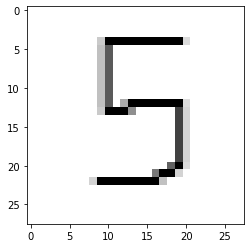

In [ ]:
# Prepares the picture "5_pic.png" for generating an adversarial example, 
# and displays it (don't forget to upload the picture when running the notebook 
# -- you can find it in the repo).

pic = ImageOps.grayscale(Image.open("5_pic.png"))  
pic = pic.resize((28,28))
pic = ImageOps.invert(pic)

preprocess = transforms.Compose([
   transforms.Resize(28),
   transforms.ToTensor(),
])
pic_tensor = preprocess(pic)[None,:,:,:]


#display picture
plt.imshow(np.reshape(pic_tensor[0].numpy().transpose(1,2,0), (28,28)), cmap = 'Greys')
plt.show(block=True)                         

#Finding the adversarial perturbation

To find an adversarial example, we find a perturbation `delta` with norm smaller than the variable `eps`. To find this delta, we use projected gradient descent, which, as you may remember, consists of the following steps: 


1.   Compute the gradient of the loss with respect to `delta`
2.   Update `delta`
3.   Project `delta` (i.e. make all entries of `delta` smaller than `eps`)

This process is very similar to how one usually trains a model. In fact, you should compare this to the code used to train our leNet5 model, and note that the only substantial differences is the projection step - and of course the fact that we are optimising with respect to `delta` instead of the weights of the model.*

You should try playing around with the values of `eps` and `n_steps` to see what happens when you make those large/small.

Warning: Depending on the picture, and the weights, some (smaller) values of `eps`might not work .

*If you looked carefully, you might also have noticed that unlike training, we don't compute `model.forward(x + delta)`. Why? 

In [ ]:
#first, predict class of picture
pic_class = model(pic_tensor).max(dim=1)[1].item()

eps = .10                   #size of admissible perturbations
delta = torch.zeros_like(pic_tensor, requires_grad=True)
opt = torch.optim.SGD([delta], lr=1e-1, momentum=.9)    
#run PGD for n_steps 
n_steps = 60
for t in range(n_steps):
    pred = model(pic_tensor + delta)
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([pic_class]))
    if t % 5 == 0:
        print(t, loss.item())
    
    opt.zero_grad()  #set gradient to 0
    loss.backward()  #backpropagate to get gradient of the loss with respect to delta
    opt.step()       #update delta
    delta.data.clamp_(-eps, eps)    #project deta to the l^∞ closed ball of 
                                    #radius eps around 0


#output results
pred = model(pic_tensor + delta)
max_class = pred.max(dim=1)[1].item()     #class predicted for the last picture 

print("Norm of perturbation is ", delta.max().item())
print("Predicted digit", max_class)
print("Confidence:", nn.Softmax(dim=1)(pred)[0, max_class].item())

plt.imshow(np.reshape((pic_tensor +delta)[0].detach().numpy().transpose(1,2,0),
                      (28,28)) , cmap='Greys')
plt.show(block=True)

# Transferability of adversarial attacks 

To finish up this tutorial, we briefly demonstrate an interesting phenomenon that takes place when working with adversarial examples. By now it should be clear that the process we followed for generating the perturbation is model-specific. More specifically the computation of the gradient of the loss with respect to `delta` depends on the weights of the model. Hence, there is no reason for an adversarial example generated for some model to work on some other model. However, researchers in the field of adversarial machine learning have noticed that this actually happens more frequently than one would expect: this phenomenon is called the transferability of adversarial attacks. 

From a security point of view, this isn't great: a big practical problem with our approach to finding adversarial examples is that we need a **lot** of information on the model we are trying to fool (namely, its weights) - this is an instance of a *white box attack*. Since the weights of models used in security critical applications are rarely publically available, white-box attacks will necessarily be *rather hard* to pull off. However, the transferability of adversarial attacks opens up new avenues for generating adversarial attacks for models with no information on the actual architecture or weights of the model (a *black box attack*), e.g. by generating adversarial attacks for some known model and using those on the model one wants to fool. See for instance https://arxiv.org/abs/1605.07277.



In [ ]:
#Define slightly different leNet5 model and training process

class leNetVariant(nn.Module):
    def __init__(self):
        super(leNetVariant, self).__init__()
        self.conv_layers = nn.Sequential( 
            nn.Conv2d(1, 6, 5),
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5),
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(16, 120, 4),
            nn.Tanh(),
        )
        self.fully_connected_layers = nn.Sequential(
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10),
            nn.Tanh(),
        )

    
    def forward(self, x):
        x = self.conv_layers(x)
        y = x.view((x.shape[0], x.shape[1]))   #flatten x 
        return self.fully_connected_layers(y)

#This function trains a leNet model for n_epochs using mini-batch gradient 
#descent with batches of size batch_size
def train_leNetVariant(batch_size, n_epochs): 
    #batch_size needs to be at least 2 otherwise training breaks 

    #prepare data
    transform = transforms.ToTensor()
    training_set = torchvision.datasets.MNIST(root='./data', train=True, 
                                            download=True, transform=transform)
    loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, 
                                          shuffle=True)

    #initialize model, loss and optimiser
    model = leNetVariant()
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = .001, momentum = .9)

    #train model using mini-batch gradient descent 
    for epoch in range(0, n_epochs):
        running_loss = 0
        for i, data in enumerate(loader, 0):
            optimizer.zero_grad()

            pt, lbl = data

            output = model.forward(pt)

            loss = loss_fn(output, lbl.long())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0 

    print('Finished Training')

    #output model
    return model


#train the leNet5 variant
other_model = leNetVariant()                               
path_leNetVariant =  './weights_leNetVariant.pth'
#check if a pre-trained model exists, if not, train a new model
if exists(path_leNetVariant):                     
    print("Loading pretrained model")
    other_model.load_state_dict(torch.load(path_leNetVariant))
else:
    print("Did not find pretrained model. Training a model instead.")
    other_model = train_leNetVariant(4, 2)
    torch.save(other_model.state_dict(), path_leNetVariant)

model.eval()

In [ ]:
pred = model(pic_tensor)
max_class = pred.max(dim=1)[1].item()     #class predicted for the last picture 

print("Predicted digit for original pic", max_class)
print("Confidence:", nn.Softmax(dim=1)(pred)[0, max_class].item())

pred = model(pic_tensor + delta)
max_class = pred.max(dim=1)[1].item()
print("Predicted digits for modified pic", max_class)
print("Confidence:", nn.Softmax(dim=1)(pred)[0, max_class].item())

# Conclusion

In this tutorial, we introduced some basic tools for generating adversarial examples and investigated how these connect with the standard supervised learning paradigm, and tested these on a standard machine learning dataset. 

There are many more ideas in the field of adversarial machine learning that we have not even mentionned so far. For instance, the reader might now be wondering how one goes about strenghtening a model in view of making it more robust to adversarial attacks. This would lead us on to the important the topic of adversarial training, which lies beyond the scope of this article. 

The interested reader should check out the wonderful tutorial written by Zico Kolter and Aleksander Madry, https://adversarial-ml-tutorial.org/introduction/, to which this tutorial owes a lot. 